#### License

In [ ]:
# SPDX-License-Identifier: Apache-2.0
#
# Copyright 2024 Fujitsu Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## User guide of FairOversampling

#### Introduction

The FairOversampling technique is based on the following paper

Author: Ruysuke Sonoda<br>
Title: Fair oversampling technique using heterogeneous clusters<br>
Affiliation: Fujitsu Ltd., 4-1-1 Kamikodanaka, Nakahara-ku, Kawasaki-shi, 211-8588, Kanagawa, Japan

and can be downloaded from<br>
https://www.sciencedirect.com/science/article/abs/pii/S0020025523006448<br>
(see also https://arxiv.org/abs/2305.13875).


The basic idea of the proposed algorithm is the following.

Class imbalance and group (e.g., race, gender, and age) imbalance are acknowledged
as two reasons in data that hinder the trade-off between fairness and utility
of machine learning classifiers. Existing techniques have jointly addressed
issues regarding class imbalance and group imbalance by proposing fair oversampling
techniques. Unlike the common oversampling techniques, which only
address class imbalance, fair oversampling techniques significantly improve the
abovementioned trade-off, as they can also address group imbalance. However,
if the size of the original clusters is too small, these techniques may cause classifier
overfitting. To address this problem, we herein develop a fair oversampling
technique using data from heterogeneous clusters. The proposed technique generates
synthetic data that have class-mix features or group-mix features to make
classifiers robust to overfitting. Moreover, we develop an interpolation method
that can enhance the validity of generated synthetic data by considering the
original cluster distribution and data noise.

In the following we demonstrate the use of the proposed Fair Oversampling algorithm.

#### Imports

Necessary imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

import fairoversampling as fo

#### Generate an imbalanced dataset

For this tutorial we define our own artificial dataset with unfair feature distributions in 2-dimensional space.

In [2]:
def simulated(n_samples = 1000, pos = .3, neg = .7, pro = .2, unp = .8,):    
    # assign label
    num_pos = int(n_samples * pos)
    num_neg = int(n_samples * neg)
    if num_pos + num_neg != n_samples:
        num_pos = n_samples - num_neg
    labels = np.zeros([n_samples, 1])
    labels[:num_pos] = 1

    # positive and unprotected sample
    pos_unp = np.random.multivariate_normal(
        [-4.0, -2], [[1, 0], [0, 1]], size=(num_pos)
    )
    # positive and protected sample
    pos_pro = np.random.multivariate_normal(
        [1.5, 0.], [[0.5*3, 0], [0, 0.5*3]], size=(num_pos)
    )
    # negative and unprotected sample
    neg_unp = np.random.multivariate_normal(
        [-1.5, 2], [[1, 0], [0, 1]], size=(num_neg)
    )
    # negative and protedted sample
    neg_pro = np.random.multivariate_normal(
        [0.5, 2], [[1, 0], [0, 1]], size=(num_neg)
    )
    # generate positive samples
    pos_groups = (np.random.rand(num_pos) <= pro) * 1
    pos_mask = pos_groups.reshape([len(pos_groups), 1])
    pos_samples = (1 - pos_mask) * pos_unp + pos_mask * pos_pro
    
    # generate negative samples
    neg_groups = (np.random.rand(num_neg) <= pro) * 1
    neg_mask = neg_groups.reshape([len(neg_groups), 1])
    neg_samples = (1 - neg_mask) * neg_unp + neg_mask * neg_pro
    # create features
    features = np.concatenate([pos_samples, neg_samples], axis = 0)
    groups = np.concatenate([pos_groups, neg_groups])
    
    
    dataset_orig = pd.DataFrame(features, columns = ["0", "1"])
    dataset_orig = dataset_orig.assign(sex = groups)
    dataset_orig = dataset_orig.assign(label = labels)
    X_orig, y_orig = dataset_orig.drop("label", axis = 1), dataset_orig["label"]
    
    return dataset_orig, X_orig, y_orig

In [3]:
#generate a dataset of 2000 instances and one sensitive attribute
pos, pro = .2, .1
neg, unp = 1-pos, 1-pro
dataset_orig, X_orig, y_orig = simulated(2000, pos, neg, pro, unp)

In [4]:
#examine a sample of the generated dataset
dataset_orig

,0,1,sex,label
0,-3.276108,-2.046063,0,1.0
1,-6.512403,-2.310317,0,1.0
2,-1.963398,-2.998658,0,1.0
3,-3.480938,-1.705945,0,1.0
4,-3.553759,-2.057061,0,1.0
...,...,...,...,...
1995,-1.337237,1.242702,0,0.0
1996,-0.903663,1.790870,0,0.0
1997,0.347076,-0.211850,1,0.0
1998,-2.037420,3.023925,0,0.0


In [5]:
#function that enables us to plot our dataset
def plot_data(X_orig, y_orig):
    color = ["blue","red"]
    marker = ["_", "+"]
    for l in [0, 1]:
        for g in [0,1]:
            X = X_orig[(y_orig == l) * (X_orig["sex"] == g)]
            plt.scatter(X["0"], X["1"], color = color[l], marker = marker[g], label=f"group{g}_label{l}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
    plt.show()

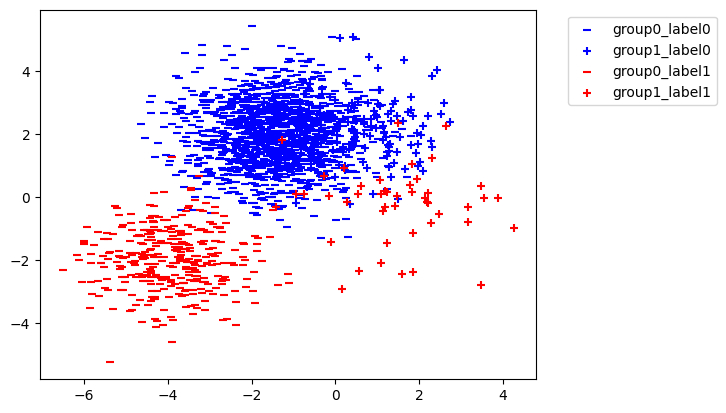

In [6]:
#plot dataset
plot_data(X_orig, y_orig)

#### Fair Oversampling

In [7]:
#function to create the intersectional groups
def convert_intersectional_group(X, protected_attributes = ["race", "sex"]):
    num_G = len(protected_attributes)
    if num_G < 2:
        return X[protected_attributes].values.reshape(-1)
    
    intersectional_group = np.zeros(len(X))
    A = [0,1]
    i = 0
    for a in list(product(A,repeat=num_G)):
        boolean = [X[protected_attributes[g]] == a[g] for g in range(num_G)]
        intersectional_group[np.prod(boolean, axis = 0, dtype = bool)] = i
        i += 1
    return intersectional_group

In [8]:
#in our case we only have one protected attribute, therefore the generated
#intersectional group A matches the column 'sex' of X_orig
A = convert_intersectional_group(X_orig, protected_attributes=["sex"])
A

array([0, 0, 0, ..., 1, 0, 0])

In [9]:
#we oversample
model = fo.FairOverSampler(alpha=1, k=5, random_state=0)
dataset_final = model.fit_resample(X_orig, y_orig, A)
dataset_final

(array([[-3.27610826, -2.04606295,  0.        ],
        [-6.51240301, -2.3103168 ,  0.        ],
        [-1.96339786, -2.9986577 ,  0.        ],
        ...,
        [-0.09129228, -1.42135572,  1.        ],
        [ 0.35008973,  0.14042437,  1.        ],
        [ 2.97569728,  0.71844935,  1.        ]]),
 array([1., 1., 1., ..., 1., 1., 1.]))